In [1]:
import os, sys, json, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from joblib import dump

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Python:", sys.version)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [2]:
# === 1) SAMPLE ===
# Auto-detect dataset path
from pathlib import Path
root = Path("/kaggle/input")
heart_path = None
for r, d, f in os.walk(root):
    for name in f:
        if "heart" in name.lower() and name.endswith(".csv"):
            heart_path = Path(r)/name
heart_path


PosixPath('/kaggle/input/heart-disease-dataset/heart.csv')

In [3]:
# Load dataset
df = pd.read_csv(heart_path)
print(df.shape)
df.head()


(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# Quick target balance
target_col = "target" if "target" in df.columns else "output"
print(df[target_col].value_counts(normalize=True))


target
1    0.513171
0    0.486829
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


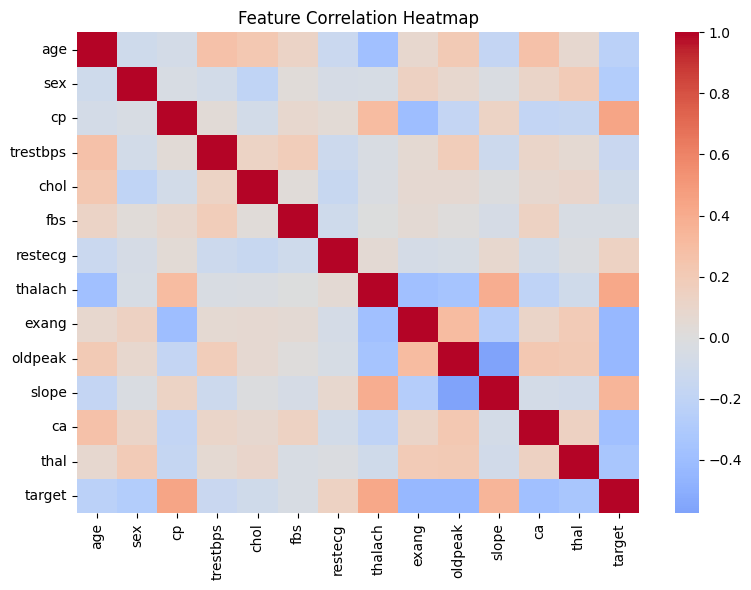

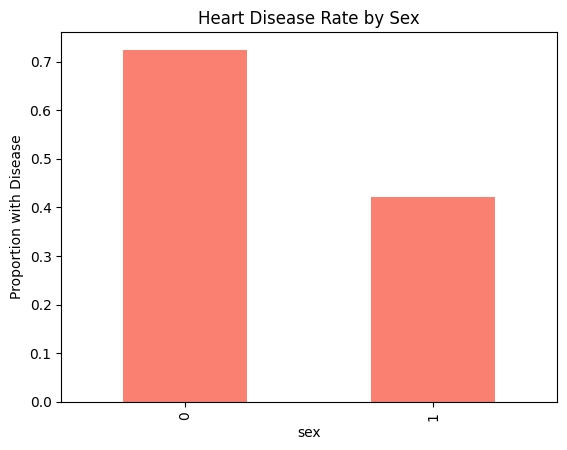

In [5]:
# === 2) EXPLORE ===
df.describe().T.head(10)

# Correlation heatmap (optional)
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout(); plt.show()

# Target distribution by sex
df.groupby("sex")[target_col].mean().plot(kind="bar", color="salmon", title="Heart Disease Rate by Sex")
plt.ylabel("Proportion with Disease"); plt.show()


In [6]:
# === 3) MODIFY ===
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=np.number).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print("Train/Test:", X_train.shape, X_test.shape)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))
])


Train/Test: (820, 13) (205, 13)


In [7]:
# === 4) MODEL ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"[CV-5] ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

hold_auc = roc_auc_score(y_test, proba)
hold_ap  = average_precision_score(y_test, proba)
print(f"[Holdout] ROC-AUC: {hold_auc:.3f} | PR-AUC: {hold_ap:.3f}")
print(classification_report(y_test, pred))


[CV-5] ROC-AUC: 0.916 ± 0.015
[Holdout] ROC-AUC: 0.930 | PR-AUC: 0.933
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       100
           1       0.76      0.91      0.83       105

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205



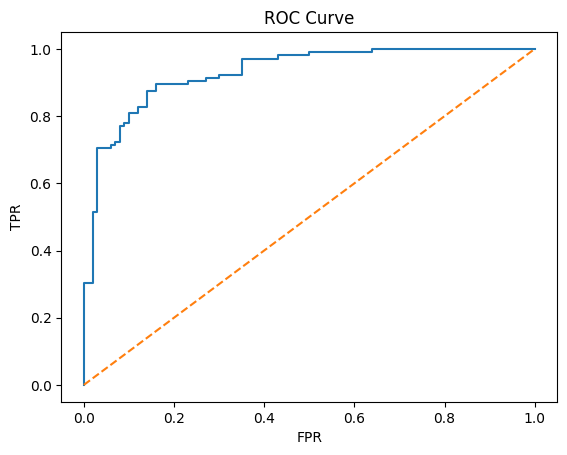

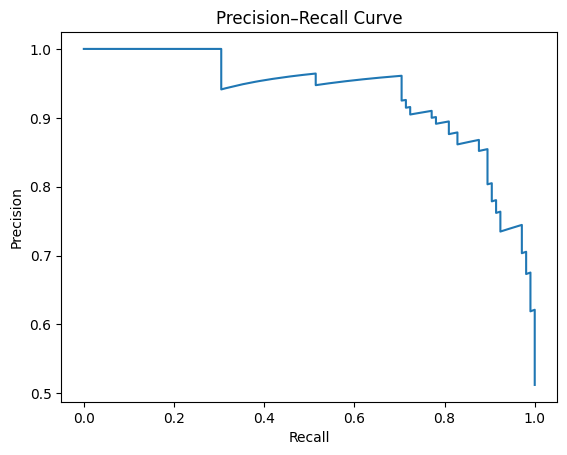

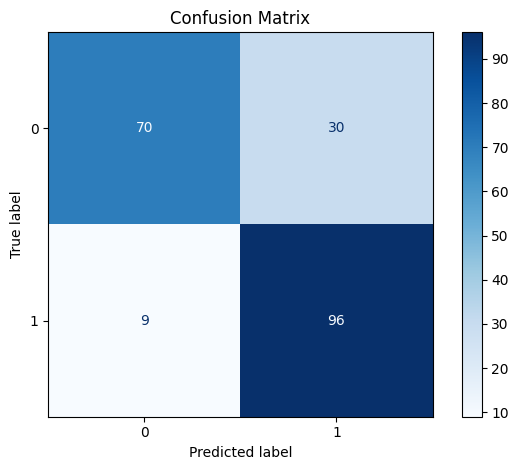

{'cv_auc_mean': 0.9156413546431231,
 'cv_auc_std': 0.014723178388129579,
 'hold_auc': 0.9300952380952381,
 'hold_pr_auc': 0.932841636394776,
 'train_size': 820,
 'test_size': 205}

In [8]:
# === 5) ASSESS ===
fpr, tpr, thr = roc_curve(y_test, proba)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

pp, rr, _ = precision_recall_curve(y_test, proba)
plt.plot(rr, pp); plt.title("Precision–Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()

# Save model + summary
ART = Path("/kaggle/working/artifacts"); ART.mkdir(exist_ok=True)
model_path = ART / f"heart_semma_lr_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
dump(pipe, model_path)
summary = {
    "cv_auc_mean": float(cv_auc.mean()),
    "cv_auc_std": float(cv_auc.std()),
    "hold_auc": float(hold_auc),
    "hold_pr_auc": float(hold_ap),
    "train_size": int(X_train.shape[0]),
    "test_size": int(X_test.shape[0])
}
json.dump(summary, open(ART/"run_summary.json","w"), indent=2)
summary
